In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Quantum generative adversarial networks with Cirq + TensorFlow {#quantum_GAN}
==============================================================

::: {.meta}
:property=\"og:description\": This demo constructs and trains a Quantum
Generative Adversarial Network (QGAN) using PennyLane, Cirq, and
TensorFlow. :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/qgan3.png>
:::

*Author: Nathan Killoran --- Posted: 11 October 2019. Last updated: 30
January 2023.*

This demo constructs a Quantum Generative Adversarial Network (QGAN)
([Lloyd and Weedbrook
(2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.040502),
[Dallaire-Demers and Killoran
(2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324))
using two subcircuits, a *generator* and a *discriminator*. The
generator attempts to generate synthetic quantum data to match a pattern
of \"real\" data, while the discriminator tries to discern real data
from fake data (see image below). The gradient of the discriminator's
output provides a training signal for the generator to improve its fake
generated data.

| 

![](../_static/demonstration_assets/QGAN/qgan.png){.align-center
width="75.0%"}

| 


Using Cirq + TensorFlow
=======================

PennyLane allows us to mix and match quantum devices and classical
machine learning software. For this demo, we will link together
Google\'s [Cirq](https://cirq.readthedocs.io/en/stable/) and
[TensorFlow](https://www.tensorflow.org/) libraries.

We begin by importing PennyLane, NumPy, and TensorFlow.


In [1]:
import numpy as np
import pennylane as qml
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt


In [2]:
sp500 = yf.download('^GSPC', start='2000-01-01', end='2023-12-31')
prices = sp500['Adj Close']
#mksdfksmf

[*********************100%***********************]  1 of 1 completed


In [3]:
# Preprocess the data: calculate returns or normalize directly
log_returns = np.log(prices / prices.shift(1)).dropna()
normalized_data = (log_returns - log_returns.mean()) / log_returns.std()

# Convert to a numpy array for training
training_data = normalized_data.values
t

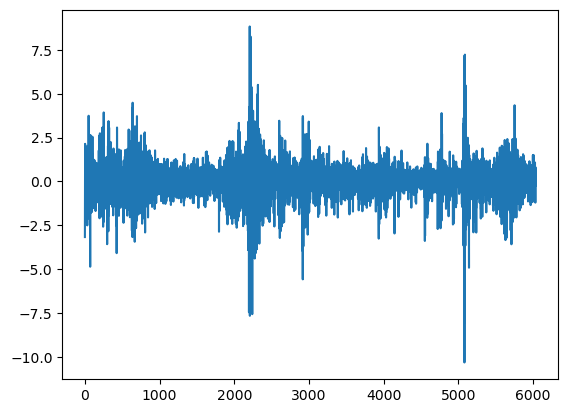

In [19]:
# plt.plot(prices)
plt.plot(training_data)

We also declare a 3-qubit simulator device running in Cirq.


In [4]:
dev = qml.device('cirq.simulator', wires=3)

Generator and Discriminator
===========================

In classical GANs, the starting point is to draw samples either from
some \"real data\" distribution, or from the generator, and feed them to
the discriminator. In this QGAN example, we will use a quantum circuit
to generate the real data.

For this simple example, our real data will be a qubit that has been
rotated (from the starting state $\left|0\right\rangle$) to some
arbitrary, but fixed, state.


In [ ]:
# def real(angles, **kwargs):
#     qml.Hadamard(wires=0)
#     qml.Rot(*angles, wires=0)

For the generator and discriminator, we will choose the same basic
circuit structure, but acting on different wires.

Both the real data circuit and the generator will output on wire 0,
which will be connected as an input to the discriminator. Wire 1 is
provided as a workspace for the generator, while the discriminator's
output will be on wire 2.


In [14]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)
    
print(qml.draw(generator)(init_disc_weights))

0: ──H─────────RX(0.41)──RY(1.45)──RZ(0.12)─╭●──RX(0.33)──RY(1.49)──RZ(-0.21)─┤  
1: ──RX(0.14)──RY(0.76)──RZ(0.44)───────────╰X────────────────────────────────┤  


We create two QNodes. One where the real data source is wired up to the
discriminator, and one where the generator is connected to the
discriminator.


In [6]:
@qml.qnode(dev)
def real_disc_circuit(disc_weights):
    training_data
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

QGAN cost functions
===================

There are two cost functions of interest, corresponding to the two
stages of QGAN training. These cost functions are built from two pieces:
the first piece is the probability that the discriminator correctly
classifies real data as real. The second piece is the probability that
the discriminator classifies fake data (i.e., a state prepared by the
generator) as real.

The discriminator is trained to maximize the probability of correctly
classifying real data, while minimizing the probability of mistakenly
classifying fake data.

$$Cost_D = \mathrm{Pr}(real|\mathrm{fake}) - \mathrm{Pr}(real|\mathrm{real})$$

The generator is trained to maximize the probability that the
discriminator accepts fake data as real.

$$Cost_G = - \mathrm{Pr}(real|\mathrm{fake})$$


In [7]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

Training the QGAN
=================

We initialize the fixed angles of the \"real data\" circuit, as well as
the initial parameters for both generator and discriminator. These are
chosen so that the generator initially prepares a state on wire 0 that
is very close to the $\left| 1 \right\rangle$ state.


In [8]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

We begin by creating the optimizer:


In [9]:
opt = tf.keras.optimizers.SGD(0.4)
opt.build([disc_weights, gen_weights])

In the first stage of training, we optimize the discriminator while
keeping the generator parameters fixed.


In [10]:
cost = lambda: disc_cost(disc_weights)

for step in range(50):
    opt.minimize(cost, [disc_weights])
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.025310218334197998
Step 5: cost = -0.3032334968447685
Step 10: cost = -0.47221313416957855
Step 15: cost = -0.5014947354793549
Step 20: cost = -0.5046252179890871
Step 25: cost = -0.5049414057284594
Step 30: cost = -0.5049733631312847
Step 35: cost = -0.5049767158925533
Step 40: cost = -0.5049770753830671
Step 45: cost = -0.5049770884215832


At the discriminator's optimum, the probability for the discriminator to
correctly classify the real data should be close to one.


In [11]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

Prob(real classified as real):  0.9998984932899475


For comparison, we check how the discriminator classifies the
generator's (still unoptimized) fake data:


In [12]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.4949215389788151


In the adversarial game we now have to train the generator to better
fool the discriminator. For this demo, we only perform one stage of the
game. For more complex models, we would continue training the models in
an alternating fashion until we reach the optimum point of the
two-player adversarial game.


In [13]:
cost = lambda: gen_cost(gen_weights)

for step in range(50):
    opt.minimize(cost, [gen_weights])
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.5943633988499641
Step 5: cost = -0.9244202077388763
Step 10: cost = -0.9911370873451233
Step 15: cost = -0.9990369081497192
Step 20: cost = -0.9998961687088013
Step 25: cost = -0.9999889135360718
Step 30: cost = -0.9999986886978149
Step 35: cost = -0.9999999403953552
Step 40: cost = -0.9999999403953552
Step 45: cost = -0.9999999403953552


At the optimum of the generator, the probability for the discriminator
to be fooled should be close to 1.


In [20]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  1.0


At the joint optimum the discriminator cost will be close to zero,
indicating that the discriminator assigns equal probability to both real
and generated data.


In [21]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.00010150671005249023


The generator has successfully learned how to simulate the real data
enough to fool the discriminator.

Let\'s conclude by comparing the states of the real data circuit and the
generator. We expect the generator to have learned to be in a state that
is very close to the one prepared in the real data circuit. An easy way
to access the state of the first qubit is through its [Bloch
sphere](https://en.wikipedia.org/wiki/Bloch_sphere) representation:


In [22]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev)
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev)
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print(f"Generator Bloch vector: {bloch_vector_generator(gen_weights)}")

NameError: name 'phi' is not defined

About the author
================
